In [7]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8')

list(data.columns)

['Unnamed: 0', 'publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(hub_url)
embeddings = embed(data['cleaned'])

print(embeddings)
print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

tf.Tensor(
[[ 0.02267956 -0.06716511  0.01718922 ... -0.0158857  -0.043926
  -0.00393031]
 [ 0.04192     0.07056528  0.09499479 ... -0.03520851 -0.0134883
   0.04670066]
 [-0.06692986 -0.00541758 -0.03079402 ...  0.02694076 -0.01263959
  -0.07979716]
 ...
 [-0.01887087  0.06309655  0.1051517  ... -0.01325584 -0.04266983
   0.01906748]
 [ 0.01090654 -0.08720968 -0.00068635 ...  0.00569523 -0.01905336
  -0.04718436]
 [ 0.0252452  -0.01673799 -0.06606335 ... -0.00096804 -0.04874956
  -0.04058736]], shape=(25914, 512), dtype=float32)
The embeddings vector is of fixed length 512


In [10]:
np.save('embeddings.npy', embeddings, allow_pickle=True, fix_imports=True)
data.to_pickle('data.pkl')

In [3]:
embeddings = np.load('embeddings.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data = pd.read_pickle('data.pkl')

In [4]:
from sklearn.preprocessing import normalize
_normalize =True


if (_normalize):
  embeddings = normalize(embeddings, norm='l2')

### PCA

#### Choosing dimensions by looking at cumulative explained variance ration

95% cut-off threshold reached with 217 components.


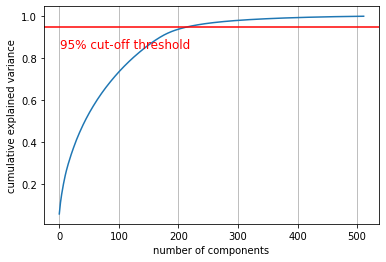

In [16]:
pca_cev = PCA().fit(embeddings)
cev_plot = np.cumsum(pca_cev.explained_variance_ratio_)
plt.plot(cev_plot)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(axis='x')

print("95% cut-off threshold reached with {} components.".format(np.argwhere(cev_plot >= 0.95)[0][0]))

In [5]:
SUBSPACE_DIM = 200

pca = PCA(n_components= SUBSPACE_DIM)
pca_embeddings = pca.fit_transform(embeddings)

print("Dimensions of embeddings matrix after PCA: ({}, {})".format(pca_embeddings.shape[0], pca_embeddings.shape[1]))

Dimensions of embeddings matrix after PCA: (25914, 200)


### SVD

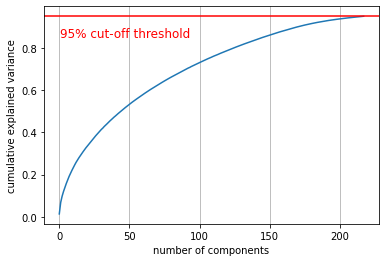

In [50]:
svd_plot = []
for i in range(1,512):
    svd_cev = TruncatedSVD(n_components=i).fit(embeddings)
    sum = svd_cev.explained_variance_ratio_.sum()
    svd_plot.append(sum)
    if sum >= 0.95:
        break


plt.plot(svd_plot)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(axis='x')

In [8]:
SUBSPACE_DIM = 200

svd = TruncatedSVD(n_components= SUBSPACE_DIM)
svd_embeddings = svd.fit_transform(embeddings)

print("Dimensions of embeddings matrix after PCA: ({}, {})".format(svd_embeddings.shape[0], svd_embeddings.shape[1]))

Dimensions of embeddings matrix after PCA: (25914, 200)


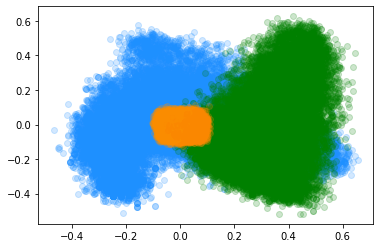

In [9]:
# plot data after pca
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], color = "dodgerblue", alpha=0.2)
plt.scatter(svd_embeddings[:, 0], svd_embeddings[:, 1], color = "green", alpha=0.2)
plt.scatter(embeddings[:, 0], embeddings[:, 1], color = "darkorange", alpha=0.2)

### Evaluating an optimal number of clusters

#### Silhouette Score

A Silhouette Score ranges between -1 to 1. A high score means that comments are well matched to their own cluster and poorly matched to their neighborhood clusters. 

In [66]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

range_n_clusters = [8, 14, 16, 18, 20]

for n_clusters in range(8,22,2):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(svd_embeddings)

    silhouette_avg = silhouette_score(X_svd, cluster_labels)
    print("For n_clusters = {} The average silhouette_score is: {}".format(n_clusters, silhouette_avg))

    samples_silhouette_values = silhouette_samples(svd_embeddings, cluster_labels)

  0%|          | 0/6 [00:00<?, ?it/s]

For n_clusters = 8 The average silhouette_score is: -0.03374069184064865


 17%|█▋        | 1/6 [00:28<02:23, 28.73s/it]

For n_clusters = 10 The average silhouette_score is: -0.013155174441635609


 33%|███▎      | 2/6 [00:59<01:57, 29.39s/it]

For n_clusters = 12 The average silhouette_score is: -0.04018548130989075


 50%|█████     | 3/6 [01:33<01:31, 30.61s/it]

For n_clusters = 14 The average silhouette_score is: -0.03820972889661789


 67%|██████▋   | 4/6 [02:06<01:02, 31.47s/it]

For n_clusters = 16 The average silhouette_score is: -0.036747366189956665


 83%|████████▎ | 5/6 [02:37<00:31, 31.26s/it]

For n_clusters = 18 The average silhouette_score is: -0.03301720321178436


100%|██████████| 6/6 [03:12<00:00, 32.14s/it]


#### Elbow Method

In [60]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_pca = sc.fit_transform(pca_embeddings) #ehemals X_normalized
X_svd = sc.fit_transform(svd_embeddings)

In [69]:
from sklearn.metrics import davies_bouldin_score

sse, db, slc = {}, {}, {}
for k in range(8, 22, 2):
    kmeans = KMeans(n_clusters = k, max_iter=1000, random_state=10).fit(X_svd)
    if k == 3: labels = kmeans.labels_
    clusters = kmeans.labels_
    sse[k] = kmeans.inertia_
    db[k] = davies_bouldin_score(X_svd, clusters)
    slc[k] = silhouette_score(X_svd, clusters)

Exception ignored in: <function tqdm.__del__ at 0x12b65da60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/tqdm/std.py", line 1150, in __del__
    self.close()
  File "/usr/local/lib/python3.8/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


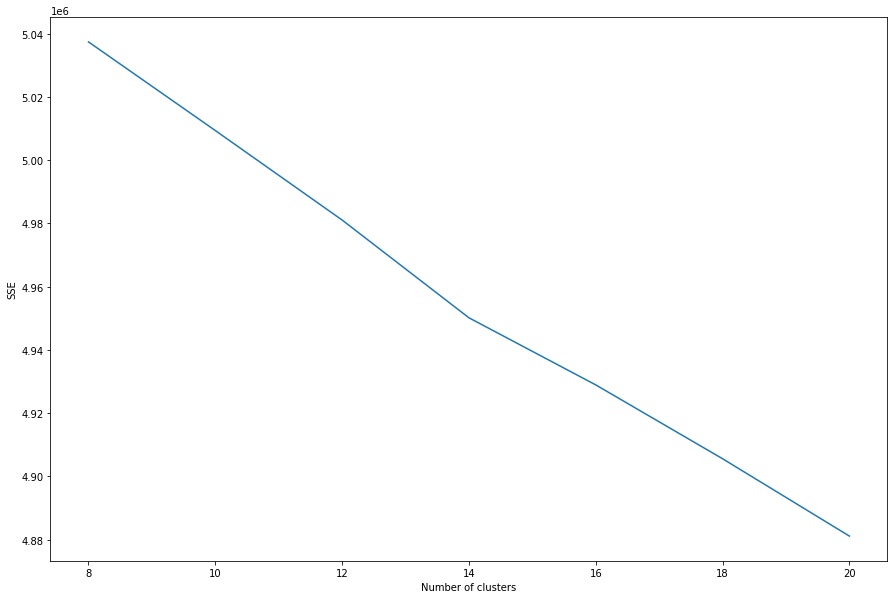

In [72]:
plt.figure(figsize=(15,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

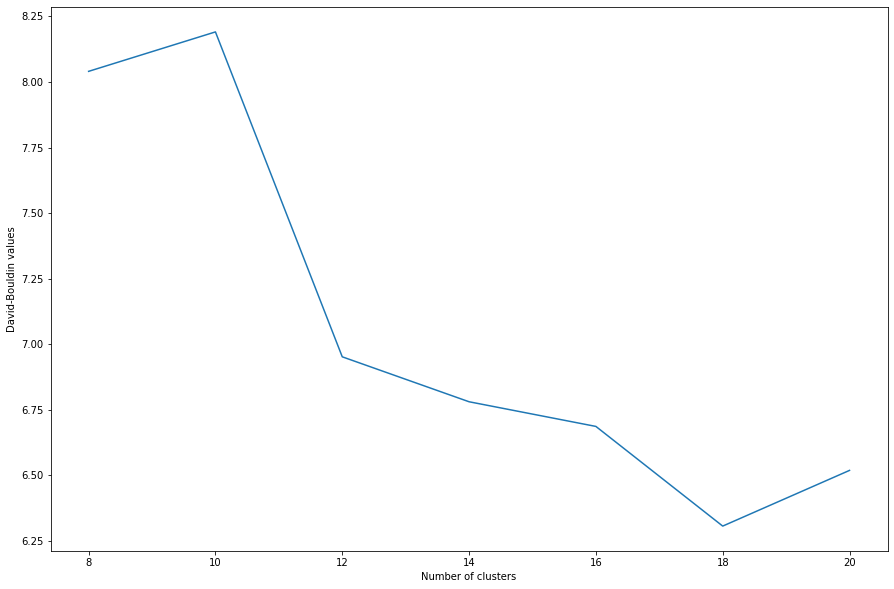

In [73]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of clusters")
plt.ylabel("David-Bouldin values")
plt.show()

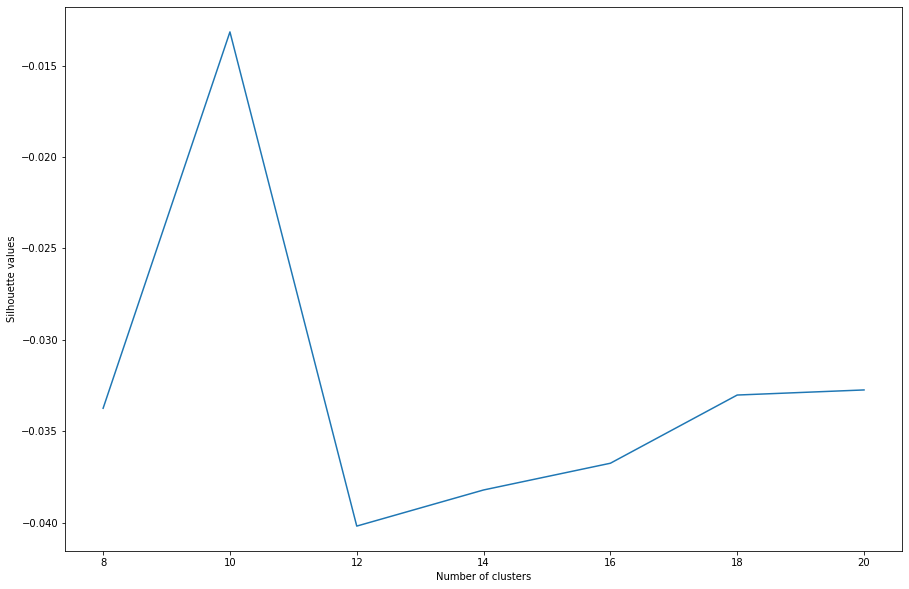

In [74]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette values")
plt.show()

### Clustering with DBSCAN

TODO: takes forevvvverrr

DBSCAN Parameter:
- eps: Max distance between two samples for them to be considered as in a neigborhood, default=0.5
- min_samples: Number of samples in a neighborhood for a point to be considered a core point, default = 5
- metric: Metric for calculating distance between instances in a feature array TODO: Find out more
- n_jobs: Used for parallelization, None means 1, -1 means using all processors

In [10]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.9, min_samples=10).fit(svd_embeddings)

In [11]:
db

DBSCAN(eps=0.9, min_samples=10)

In [12]:
components = db.components_
labels = db.labels_
core_sample_indices = db.core_sample_indices_

In [13]:
labels
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

From docs: Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.

In [14]:
frequencies

array([[   -1,  9691],
       [    0, 16043],
       [    1,    14],
       [    2,    16],
       [    3,    26],
       [    4,    10],
       [    5,    13],
       [    6,    11],
       [    7,    15],
       [    8,    15],
       [    9,    19],
       [   10,    11],
       [   11,     9],
       [   12,    10],
       [   13,    11]])